In [1]:
import numpy as np
import pandas as pd
from numpy.random import choice, normal, gamma, poisson
from scipy.stats import norm, invgamma
from scipy.stats import bernoulli
import scipy
import seaborn as sns
import math
from importlib import reload
from scipy.io import savemat

import matplotlib.pyplot as plt
import ParticleFilter
import Poisson_Tree_Particle_Filter

from scipy.stats import norm

from Tree_Node import *


In [2]:
seed = 17

# Data

In [3]:
def get_s_1(s_0, v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    
    return s_0 + v_0*dt + (1/2)*a_0*(dt**2)

def get_v_1(v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    
    return v_0 + a_0*dt

def generate_data(n_res, res, sigma_theta, s_x_0, v_x_0, s_y_0, v_y_0, gamma_shape=2, gamma_scale=1, seed=0):
    np.random.seed(seed)
    
    #generate tau
    tau = [0]
    
    while tau[-1] < n_res*res:
        tau.append(tau[-1] + np.random.gamma(shape=gamma_shape, scale=gamma_scale))

    _ = tau.pop()
    tau = np.array(tau)
    kT = len(tau)
    
    #generate acceleration at tau
    a_x_tau = np.random.normal(loc=0.0, scale=sigma_theta, size=kT)
    a_y_tau = np.random.normal(loc=0.0, scale=sigma_theta, size=kT)
           
    #compute states variables at tau
    s_x_tau, v_x_tau, = np.empty(kT), np.empty(kT)
    s_y_tau, v_y_tau, = np.empty(kT), np.empty(kT)
        
    s_x_tau[0], v_x_tau[0] = s_x_0, v_x_0
    s_y_tau[0], v_y_tau[0] = s_y_0, v_y_0
    
    for i1 in range(1, kT):
        i0 = i1 - 1
        s_x_tau[i1] = get_s_1(
            s_0=s_x_tau[i0],
            v_0=v_x_tau[i0],
            a_0=a_x_tau[i0],
            t_0=tau[i0],
            t_1=tau[i1],
        )
        s_y_tau[i1] = get_s_1(
            s_0=s_y_tau[i0],
            v_0=v_y_tau[i0],
            a_0=a_y_tau[i0],
            t_0=tau[i0],
            t_1=tau[i1],
        )
        v_x_tau[i1] = get_v_1(
            v_0=v_x_tau[i0],
            a_0=a_x_tau[i0],
            t_0=tau[i0],
            t_1=tau[i1],
        )
        v_y_tau[i1] = get_v_1(
            v_0=v_y_tau[i0],
            a_0=a_y_tau[i0],
            t_0=tau[i0],
            t_1=tau[i1],
        )
    
    
    #compute path/trajectory
    s_x, s_y = np.empty(n_res+1), np.empty(n_res+1)
    
    s_x[0], s_y[0] = s_x_0, s_y_0
    
    tau_index = 0
    for i in range(1, n_res+1):
        t = i*res
        
        #find last tau before this t
        while t > tau[tau_index]:
            tau_index += 1
        
            if tau_index == kT:
                break
            
        tau_index -= 1
        
        #compute coordinates at t
        s_x[i] = get_s_1(
            s_0=s_x_tau[tau_index],
            v_0=v_x_tau[tau_index],
            a_0=a_x_tau[tau_index],
            t_0=tau[tau_index],
            t_1=t,
        )
        s_y[i] = get_s_1(
            s_0=s_y_tau[tau_index],
            v_0=v_y_tau[tau_index],
            a_0=a_y_tau[tau_index],
            t_0=tau[tau_index],
            t_1=t,
        )
                
    return s_x_tau, s_y_tau, s_x, s_y, tau, a_x_tau, a_y_tau


def generate_observations(delta_t, res, mean, std, x, y):   
    step = int(delta_t / res)
    x_noisy, y_noisy = x[::step] + np.random.normal(mean, std, x[::step].size), y[::step] + np.random.normal(mean, std, y[::step].size)
    
    return x_noisy, y_noisy

T = 200
delta_t = 5
res = 1       #resolution for plotting hidden process

n_res = int(T / res)
n = int(T / delta_t)

sigma_theta = 10.0
sigma_obs = 200.0

gamma_shape = 10.0
gamma_scale = 2.5

lam = scipy.stats.gamma.cdf(delta_t, gamma_shape, scale=gamma_scale)
lam = T / (gamma_shape*gamma_scale*n)

s_x_0, s_y_0 = 64000, 29000
v_x_0, v_y_0 = 400, 0

s_x_tau, s_y_tau, s_x, s_y, tau_true, a_x_tau, a_y_tau = generate_data(
    n_res,
    res,
    sigma_theta,
    s_x_0=s_x_0,
    s_y_0=s_y_0,
    v_x_0=v_x_0,
    v_y_0=v_y_0,
    gamma_shape=gamma_shape,
    gamma_scale=gamma_scale,
    seed=seed
)

x_obs, y_obs = generate_observations(delta_t, res, mean=0.0, std=sigma_obs, x=s_x, y=s_y)

# Functions and settings

In [4]:
num_particles = 1000
sigma_obs = 1000

gamma_shape = gamma_shape 
gamma_scale = gamma_scale 

sigma_theta = sigma_theta 

x_obs, y_obs = np.insert(x_obs, 0, 64000), np.insert(y_obs, 0, 29000)

In [5]:
sigma_adjust = delta_t / 1000
capacity = n*3
weights = np.ones(num_particles) / np.sum(np.ones(num_particles))
log_weights = np.zeros(num_particles)
store_weights = np.zeros([num_particles, n])

particles =  {'s_x' : np.zeros([num_particles, capacity]),
              's_y' : np.zeros([num_particles, capacity]),
              'v_x' : np.zeros([num_particles, capacity]),
              'v_y' : np.zeros([num_particles, capacity]),
              'a_x' : np.zeros([num_particles, capacity]),
              'a_y' : np.zeros([num_particles, capacity]),
              'tau' : np.zeros([num_particles, capacity]),}
                  
k = np.zeros(num_particles)

capacity = 500
expectation_x,  expectation_y = np.zeros(n), np.zeros(n)

num_unique_particles = np.zeros(n)
x_temp, y_temp = np.zeros([num_particles, n]), np.zeros([num_particles, n])
ess = np.zeros(n)

In [6]:
def get_space(s_0, v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    return s_0 + v_0 * dt + (1 / 2) * a_0 * (dt ** 2)

def get_velocity(v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    return v_0 + a_0 * dt

def get_temporary_position(j, current_t, particles, k, delta_t):
    x_temp = get_space(particles['s_x'][j, k[j]-1], particles['v_x'][j, k[j]-1], particles['a_x'][j, k[j]-1], particles['tau'][j, k[j]-1], current_t * delta_t)
    y_temp = get_space(particles['s_y'][j, k[j]-1], particles['v_y'][j, k[j]-1], particles['a_y'][j, k[j]-1], particles['tau'][j, k[j]-1], current_t * delta_t)
    return x_temp, y_temp
    

def get_likelihood(x_temp, x_obs, y_temp, y_obs, sigma_obs):
    pobsx_given_x, pobsy_given_y = norm.pdf(x_temp, x_obs, sigma_obs), norm.pdf(y_temp, y_obs, sigma_obs) 
    return pobsx_given_x * pobsy_given_y

def logLikelihood(x, mu, sigma):
    return - (1 / 2) * np.log(2*np.pi) - (1 / 2) * np.log(sigma ** 2) - (1 / (2 * sigma ** 2)) * (x - mu)**2

def log_weights(x_temp, x_obs, y_temp, y_obs, sigma_obs):
    loglikelihood_x = logLikelihood(x_temp, x_obs, sigma_obs)
    loglikelihood_y = logLikelihood(y_temp, y_obs, sigma_obs)
    return loglikelihood_x + loglikelihood_y
    
def init_particles(k, lam, num_particles, delta_t, particles, sigma_theta):
    k = np.random.poisson(lam=lam, size=num_particles) + 1

    for j in range(num_particles):
        
        ts = delta_t * np.random.uniform(0, 1, k[j]-1)
        ts = np.sort(ts)

        particles['s_x'][j, 0] = s_x_0
        particles['s_y'][j, 0] = s_y_0
        particles['v_x'][j, 0] = v_x_0
        particles['v_y'][j, 0] = v_y_0
        particles['a_x'][j, 0] = np.random.normal(0, sigma_theta)
        particles['a_y'][j, 0] = np.random.normal(0, sigma_theta)
        particles['tau'][j, 0] = 0


        for i in range(1, int(k[j])):

            particles['tau'][j, i] = ts[i-1]
            particles['a_x'][j, i] = np.random.normal(0, sigma_theta)
            particles['a_y'][j, i] = np.random.normal(0, sigma_theta)
            particles['s_x'][j, i] = get_space(particles['s_x'][j, i-1], particles['v_x'][j, i-1], particles['a_x'][j, i-1], particles['tau'][j, i-1], particles['tau'][j, i])
            particles['s_y'][j, i] = get_space(particles['s_y'][j, i-1], particles['v_y'][j, i-1], particles['a_y'][j, i-1], particles['tau'][j, i-1], particles['tau'][j, i])
            particles['v_x'][j, i] = get_velocity(particles['v_x'][j, i-1], particles['a_x'][j, i-1], particles['tau'][j, i-1], particles['tau'][j, i])
            particles['v_y'][j, i] = get_velocity(particles['v_y'][j, i-1], particles['a_y'][j, i-1], particles['tau'][j, i-1], particles['tau'][j, i])
            
    return k, particles


def birth_move(current_t, num_particles, k, particles, delta_t, sigma_theta):
    for j in range(num_particles):
        k[j] = int(k[j])
        ts = particles['tau'][j, k[j]-1] + (current_t * delta_t - particles['tau'][j, k[j]-1])*np.random.uniform(0, 1)
        k[j] = k[j] + 1
        #evaluate x and v in the new tau
        particles['tau'][j, k[j] - 1] = ts
        particles['a_x'][j, k[j] - 1] = np.random.normal(0, sigma_theta)
        particles['a_y'][j, k[j] - 1] = np.random.normal(0, sigma_theta)
        particles['s_x'][j, k[j]  -1] = get_space(particles['s_x'][j, k[j]-2], particles['v_x'][j, k[j]-2], particles['a_x'][j, k[j] - 2], particles['tau'][j, k[j]-2], ts)
        particles['s_y'][j, k[j] - 1] = get_space(particles['s_y'][j, k[j]-2], particles['v_y'][j, k[j]-1], particles['a_y'][j, k[j] - 2], particles['tau'][j, k[j]-2], ts)
        particles['v_x'][j, k[j] - 1] = get_velocity(particles['v_x'][j, k[j]-2], particles['a_x'][j, k[j]-2], particles['tau'][j, k[j] - 1], ts)
        particles['v_y'][j, k[j] - 1] = get_velocity(particles['v_y'][j, k[j]-2], particles['a_y'][j, k[j]-2], particles['tau'][j, k[j] - 1], ts)
    
    return k, particles

                        
def multiple_birth_move(current_t, j, k, particles, sigma_theta):
    k_new = 1
    #k_new = 2*np.ones(n)
    
    #ts = particles(j,tau,k(j)) + delta_t*rand(1,k_new(j));
    ts = particles['tau'][j, k[j]-1] + ((current_t+1) * delta_t - particles['tau'][j, k[j]-1])*np.random.uniform(0, 1, k_new)
    ts = np.sort(ts)
    
        
    for i in range(k_new):
        particles['tau'][j, k[j] + i] = ts[i]
        particles['a_x'][j, k[j] + i] = np.random.normal(0, sigma_theta)
        particles['a_y'][j, k[j] + i] = np.random.normal(0, sigma_theta)
        particles['s_x'][j, k[j] + i] = get_space(particles['s_x'][j, k[j]+i-1], particles['v_x'][j, k[j]+i-1], particles['a_x'][j, k[j] + i - 1], particles['tau'][j, k[j]+i-1], ts[i])
        particles['s_y'][j, k[j] + i] = get_space(particles['s_y'][j, k[j]+i-1], particles['v_y'][j, k[j]+i-1], particles['a_y'][j, k[j] + i - 1], particles['tau'][j, k[j]+i-1], ts[i]) 
        
        particles['v_x'][j, k[j] + i] = get_velocity(particles['v_x'][j, k[j]+i-1], particles['a_x'][j, k[j]+i-1], particles['tau'][j, k[j] + i - 1], ts[i])
        particles['v_y'][j, k[j] + i] = get_velocity(particles['v_y'][j, k[j]+i-1], particles['a_y'][j, k[j]+i-1], particles['tau'][j, k[j] + i - 1], ts[i])
    k[j] = k[j] + k_new
    
    return k, particles
    
    
def resample(current_t, weights, num_particles):
    
    M = len(weights)
    
    ni = np.random.permutation(M)
    weights = weights[ni]
    
    inds = np.zeros(num_particles)
    
    weights = weights/np.sum(weights)
    cdf = np.cumsum(weights)
    
    cdf[-1] = 1
    
    p = np.linspace(np.random.uniform(0, 1) * (1 / num_particles), 1, num_particles)
    picked = np.zeros(M)
                    
    j=0
    for i in range(num_particles):
        while (j < M) & (cdf[j] < p[i]):
            j += 1
        picked[j] += 1
    
    rind = 0
    for i in range(M):
        if picked[i] > 0:
            for j in range(int(picked[i])):
                inds[rind] = int(ni[i])
                rind = rind + 1
                
    return inds.astype(int)

def adjust_move(current_t, j, particles, k, sigma_adjust):
    #new tau
    ts = np.random.normal(particles['tau'][j, k[j]-1], sigma_adjust)
    #evaluate x and v in the new tau
    particles['tau'][j, k[j]-1] = ts
    particles['a_x'][j, k[j]-1] = particles['a_x'][j, k[j]-1]
    particles['a_y'][j, k[j]-1] = particles['a_y'][j, k[j]-1]
    particles['s_x'][j, k[j]-1] = get_space(particles['s_x'][j, k[j]-2], particles['v_x'][j, k[j]-2], particles['a_x'][j, k[j]-2], particles['tau'][j, k[j]-2], ts)
    particles['s_y'][j, k[j]-1] = get_space(particles['s_y'][j, k[j]-2], particles['v_y'][j, k[j]-2], particles['a_y'][j, k[j]-2], particles['tau'][j, k[j]-2], ts)
    particles['v_x'][j, k[j]-1] = get_velocity(particles['v_x'][j, k[j]-2], particles['a_x'][j, k[j]-2], particles['tau'][j, k[j]-2], ts)
    particles['v_y'][j, k[j]-1] = get_velocity(particles['v_y'][j, k[j]-2], particles['a_y'][j, k[j]-2], particles['tau'][j, k[j]-2], ts) 
    
    return particles
                    

def compute_survivor_probability(current_t, num_particles, delta_t, particles, k, gamma_shape, gamma_scale):
    p = np.zeros(num_particles)
    
    for j in range(num_particles):
        p[j] = scipy.stats.gamma.cdf((current_t + 1) * delta_t - particles['tau'][j, k[j]-1], gamma_shape, gamma_scale) - scipy.stats.gamma.cdf(0, gamma_shape, gamma_scale)
        #print(p[j], particles['tau'][j, k[j]-1])
    S = np.ones(num_particles) - p
    
    return S
    
 

# Algorithm

In [7]:
np.random.seed(11)

In [8]:
def iterate(k, lam, num_particles, delta_t, particles, sigma_theta, x_obs, y_obs, weights, store_weights, sigma_adjust, gamma_shape, gamma_scale, ess, x_temp, y_temp, num_unique_particles, expectation_x, expectation_y):
    k, particles = init_particles(k, lam, num_particles, delta_t, particles, sigma_theta)
    for t in range(n):
        if t == 0: 
            for j in range(num_particles):
                x_temp[j, t], y_temp[j, t] = get_temporary_position(j, t, particles, k, delta_t)
                
            #print(x_temp[j, t], y_temp[j, t])
            weights = get_likelihood(x_temp[:, t], x_obs[t], y_temp[:, t], y_obs[t], sigma_obs)
            #print(x_temp[:, t], x_obs[t])
            weights = weights / np.sum(weights)
            
            store_weights[:, t] = weights
        
        else:
        
            S = compute_survivor_probability(t, num_particles, delta_t, particles, k, gamma_shape, gamma_scale)
            alpha = np.random.binomial(1, S, size = num_particles)
            #print(S, alpha)
            #self.birth_move(t)
            for j in range(num_particles):
                if k[j] == 1:
                    alpha[j] == 0
                
                if alpha[j] == 1:
                    x_temp[j, t], y_temp[j, t] = get_temporary_position(j, t, particles, k, delta_t)
                
                    prev_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs) 
                    
                    particles = adjust_move(t, j, particles, k, sigma_adjust)
                    x_temp[j, t], y_temp[j, t] = get_temporary_position(j, t, particles, k, delta_t)
                                                                                                               
                    curr_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs)
                    
                    #weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * S[j])
                    weights[j] = curr_likelihood
                    
                    #if (prev_likelihood * S[j] != 0):
                    #    weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * S[j])
                    #else:
                    #    weights[j] = (curr_likelihood * 1/2)
                
                else:
                        
                    x_temp[j, t],  y_temp[j, t] = get_temporary_position(j, t, particles, k, delta_t)
                    
                    prev_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs)
                    
                    k, particles = multiple_birth_move(t, j, k, particles, sigma_theta)
                    x_temp[j, t],  y_temp[j, t] = get_temporary_position(j, t, particles, k, delta_t)
                    
                    curr_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs)
                    
                    weights[j] = curr_likelihood
                    
                    #weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * (1 - S[j]) * (1 / ((t+1)*delta_t - particles['tau'][j, k[j]-1])))
        
                    #if (prev_likelihood * (1 - S[j]) != 0) and ((t+1) * delta_t - particles['tau'][j, k[j]-1] != 0):
                    #    weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * (1 - S[j]) * (1 / ((t+1)*delta_t - particles['tau'][j, k[j]-1])))
                    #else:
                    #    weights[j] = curr_likelihood * 1 / 2
            #print(particles['tau'][:, k[9]])
            
            if (np.sum(weights[:]) != 0):
                weights = weights / np.sum(weights)
            #print(weights)
            store_weights[:, t] = weights 
            
        expectation_x[t] = np.matmul(weights, x_temp[:, t])
        expectation_y[t] = np.matmul(weights, y_temp[:, t])
        
        if np.sum(weights**2) != 0:
            ess[t] = 1/np.sum(weights**2)
            if (ess[t] < 0.5*num_particles) & (t < n) :
                inds = resample(t, weights, num_particles)
                num_unique_particles[t] = len(np.unique(inds))
                for key in particles.keys():
                    particles[key] = particles[key][inds]
                k = k[inds]
                weights = np.ones(num_particles) / np.sum(np.ones(num_particles))  
            else : 
                num_unique_particles[t] = num_unique_particles[t - 1]
        else:
            num_unique_particles[t] = num_unique_particles[t - 1]
    
    return choice(np.arange(num_particles), 1, p=store_weights[:, -1]), particles, k, x_temp, y_temp


In [9]:
%%time

S, particles, k, x_temp, y_temp = iterate(k, lam, num_particles, delta_t, particles, sigma_theta, x_obs, y_obs, weights, store_weights, sigma_adjust, gamma_shape, gamma_scale, ess, x_temp, y_temp, num_unique_particles, expectation_x, expectation_y)

Wall time: 26.1 s


In [10]:
particles['s_y'][S, 0 : 22][0]

array([29000.        , 29002.0817954 , 28610.40618074, 28440.45580347,
       25492.37054798, 25045.91670674, 24358.65834003, 20236.60861229,
       19558.683285  , 16723.76386916, 14006.62930725, 13159.33369048,
       12476.09467916, 12098.01512922, 12295.39890266, 12825.90260559,
       14512.81072474, 15298.45311538, 15757.93683332, 16583.83365441,
       18865.99532946, 19055.19093155])

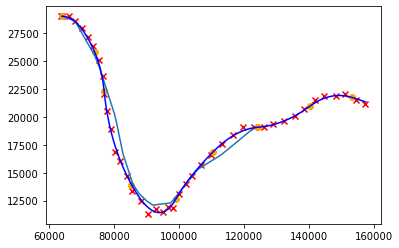

In [11]:
plt.plot(particles['s_x'][S, 0 : 22][0], particles['s_y'][S, 0 : 22][0])
    
plt.plot(s_x, s_y, color='blue')
plt.scatter(x_obs, y_obs, marker='x', color='red')
plt.scatter(s_x_tau, s_y_tau, marker='o', color='orange')

In [12]:
%%time 

ITERATIONS = 500

sampled_trajectories = {'s_x': [],
                       's_y': [],
                       'v_x': [],
                       'v_y': [],
                       'a_x': [],
                       'a_y': [],
                       'tau': [],
                       'x_temp' : [],
                       'y_temp' : []}


final_nodes = [S[0]]


for i in range(ITERATIONS):
    if i % 1 == 0:
        print(i)
    S, particles, k, x_temp, y_temp = iterate(k, lam, num_particles, delta_t, particles, sigma_theta, x_obs, y_obs, weights, store_weights, sigma_adjust, gamma_shape, gamma_scale, ess, x_temp, y_temp, num_unique_particles, expectation_x, expectation_y)
    #final_nodes.append(S[0])

    sampled_trajectories['s_x'].append(particles['s_x'][S, 0 : 22][0])
    sampled_trajectories['s_y'].append(particles['s_y'][S, 0 : 22][0])
    sampled_trajectories['v_x'].append(particles['v_x'][S, 0 : 22][0])
    sampled_trajectories['v_y'].append(particles['v_y'][S, 0 : 22][0])
    sampled_trajectories['a_x'].append(particles['a_x'][S, 0 : 22][0])
    sampled_trajectories['a_y'].append(particles['a_y'][S, 0 : 22][0])
    sampled_trajectories['tau'].append(particles['tau'][S, 0 : 22][0])
    sampled_trajectories['x_temp'].append(x_temp[S, :])
    sampled_trajectories['y_temp'].append(y_temp[S, :])
        
    #trajectories = pd.DataFrame(np.transpose(sampled_trajectories))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<AxesSubplot:ylabel='Density'>

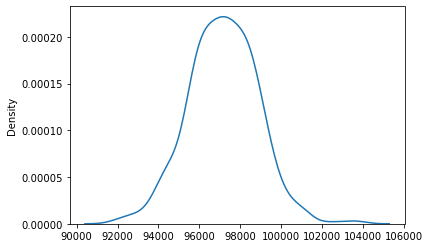

In [13]:
sns.kdeplot(np.array(sampled_trajectories['x_temp']).reshape(500, 40)[:, 20])

In [18]:
len(sampled_trajectories['tau'])

500

# Evaluate at observation times

In [35]:
np.array(sampled_trajectories['x_temp']).shape

(500, 1, 40)

In [36]:
delta_taus = []

In [37]:
for v in sampled_trajectories['tau']:
    delta_taus.extend(np.diff(v))


In [38]:
delta_taus = delta_taus[5:]

In [40]:
delta_taus = np.array(delta_taus)[np.array(delta_taus) > 0]

In [1]:
import scipy.stats as stats
sns.kdeplot(np.array(delta_taus)[np.array(delta_taus) >0])
x = np.linspace (0, 150, 150) 

#calculate pdf of Gamma distribution for each x-value
y = stats.gamma.pdf(x, a=10, scale=2.5)

#create plot of Gamma distribution
plt.plot(x, y)


NameError: name 'sns' is not defined

In [51]:
dist = (np.array(delta_taus)[np.array(delta_taus) >0] + 10)

from numpy import savetxt

In [52]:
savetxt('gibbs_mk.csv', dist, delimiter=',')